In [3]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from src.data_processing.loader import load_feature_vector_data


In [4]:
# Read data
df = load_feature_vector_data()

# Select features for clustering
features = ['trade_frequency', 'average_trade_size', 'unique_traders',
            'max_market_cap', 'initial_liquidity', 'price_volatility',
            'total_trades', 'lifetime_seconds']

# Create feature matrix
X = df[features]

# Display basic statistics
print(X.describe())

# %%
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


       trade_frequency  average_trade_size  unique_traders  max_market_cap  \
count      2000.000000         2000.000000     2000.000000     2000.000000   
mean        207.695234            0.193977      502.208500       70.826189   
std         248.016360            0.211205      387.160092       12.023876   
min           0.181504            0.001625        5.000000        0.814775   
25%          15.223911            0.041417      248.000000       66.643629   
50%         107.333009            0.058935      282.000000       71.473236   
75%         314.847663            0.420646      782.000000       76.204102   
max        1220.895326            0.861252     3280.000000       85.007996   

       initial_liquidity  price_volatility  total_trades  lifetime_seconds  
count        2000.000000      2.000000e+03   2000.000000      2.000000e+03  
mean            1.909880      4.630061e-08   2936.652000      5.712712e+05  
std             4.750926      1.835046e-08   1486.061923      6.42

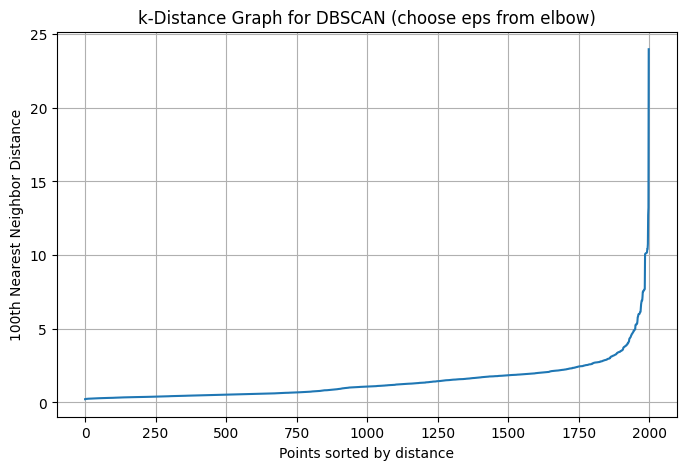

In [10]:
# Use k-distance plot to find a good range of values for eps

from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# k = min_samples, often ~2-4% of dataset size
k = 100
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Get distance to the k-th nearest neighbor (sort to find elbow)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.ylabel(f"{k}th Nearest Neighbor Distance")
plt.xlabel("Points sorted by distance")
plt.title("k-Distance Graph for DBSCAN (choose eps from elbow)")
plt.grid(True)
plt.show()


In [ ]:
# Define grid search ranges

eps_values = np.arange(1.25, 5, 0.25)  # Elbow on k-Distance graph is around 1 to 5
min_samples_values = np.arange(25, 200, 25)  # Given theres 2000 tokens to cluster, we wouldn't expect more than 10 clusters so go test values around 100

In [12]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Initialize score dictionaries
silhouette_scores = {}
ch_scores = {}
dbi_scores = {}

# Evaluate all combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 1:
            # Compute and store scores
            silhouette_scores[(eps, min_samples)] = silhouette_score(X_scaled, labels)
            ch_scores[(eps, min_samples)] = calinski_harabasz_score(X_scaled, labels)
            dbi_scores[(eps, min_samples)] = davies_bouldin_score(X_scaled, labels)

# Find best parameters for each metric
best_params_silhouette = max(silhouette_scores.items(), key=lambda x: x[1])
best_params_ch = max(ch_scores.items(), key=lambda x: x[1])
best_params_dbi = min(dbi_scores.items(), key=lambda x: x[1])  # Lower is better

# Print the best results
print("Best by Silhouette Score:", best_params_silhouette)
print("Best by Calinski-Harabasz Index:", best_params_ch)
print("Best by Davies-Bouldin Index:", best_params_dbi)


Best by Silhouette Score: ((np.float64(1.75), np.int64(25)), np.float64(0.4413401974121666))
Best by Calinski-Harabasz Index: ((np.float64(1.5), np.int64(125)), np.float64(423.57627689840655))
Best by Davies-Bouldin Index: ((np.float64(1.25), np.int64(125)), np.float64(1.74523726249139))


In [5]:
# Calinksi-Harabasz gives More compact, well-separated clusters when the value is high, we will use the values given by this metric so
# eps = 1.5 and min_samples = 125

# Create model

dbscan_ch = DBSCAN(eps=1.5, min_samples=125)

# Fit DBSCAN to the scaled data
dbscan_labels_ch = dbscan_ch.fit_predict(X_scaled)

# Store db scan labels
df['dbscan_cluster'] = dbscan_labels_ch

# Number of clusters and noise points (label = -1 for noise)
n_clusters_ch = len(set(dbscan_labels_ch)) - (1 if -1 in dbscan_labels_ch else 0)
n_noise_ch = list(dbscan_labels_ch).count(-1)

print(f"DBSCAN Clusters (CH-opt): {n_clusters_ch}")
print(f"DBSCAN Noise Points (CH-opt): {n_noise_ch}")

DBSCAN Clusters (CH-opt): 2
DBSCAN Noise Points (CH-opt): 445


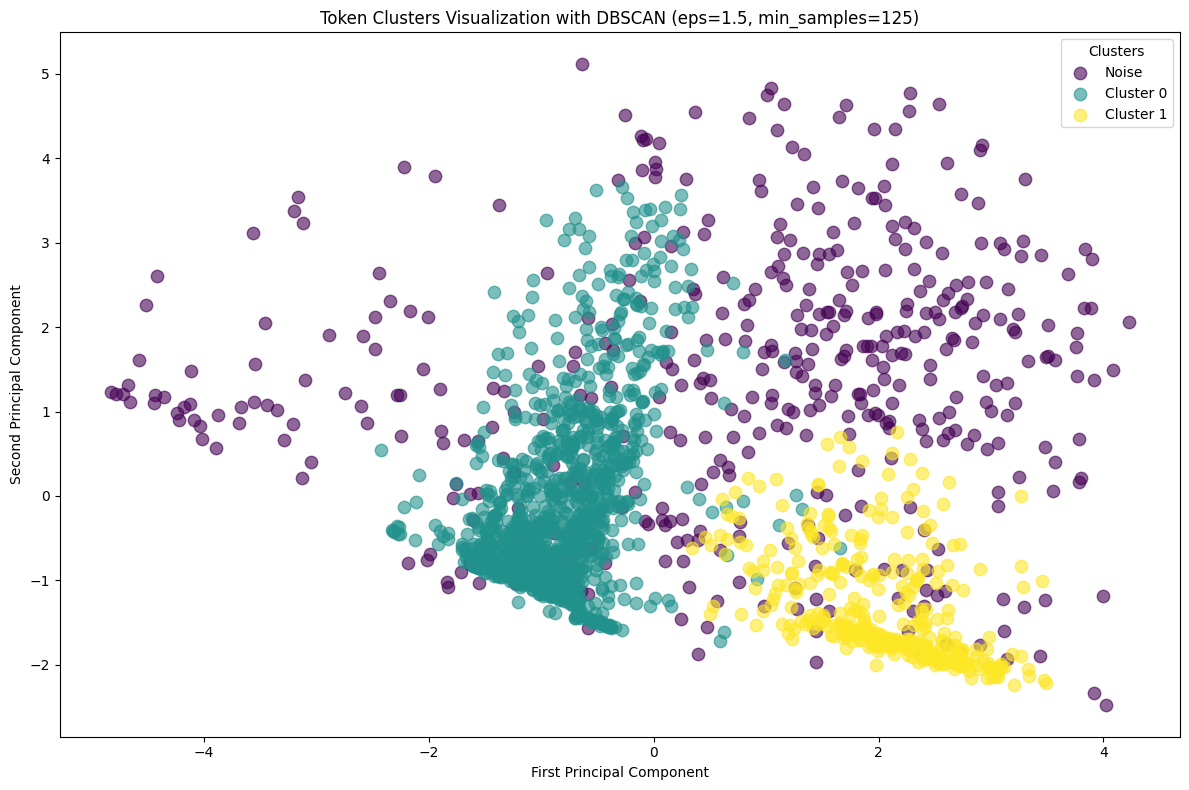

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get unique DBSCAN cluster labels (including noise labeled as -1)
unique_clusters_dbscan = np.unique(df['dbscan_cluster'])
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters_dbscan)))

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each cluster with its corresponding color
for i, cluster in enumerate(unique_clusters_dbscan):
    cluster_points = X_pca[df['dbscan_cluster'] == cluster]
    
    # Set label for noise points
    label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                color=colors[i], label=label, alpha=0.6, s=80)

# Add labels and title
plt.title(f'Token Clusters Visualization with DBSCAN (eps=1.5, min_samples=125)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(title="Clusters")
plt.tight_layout()
plt.show()


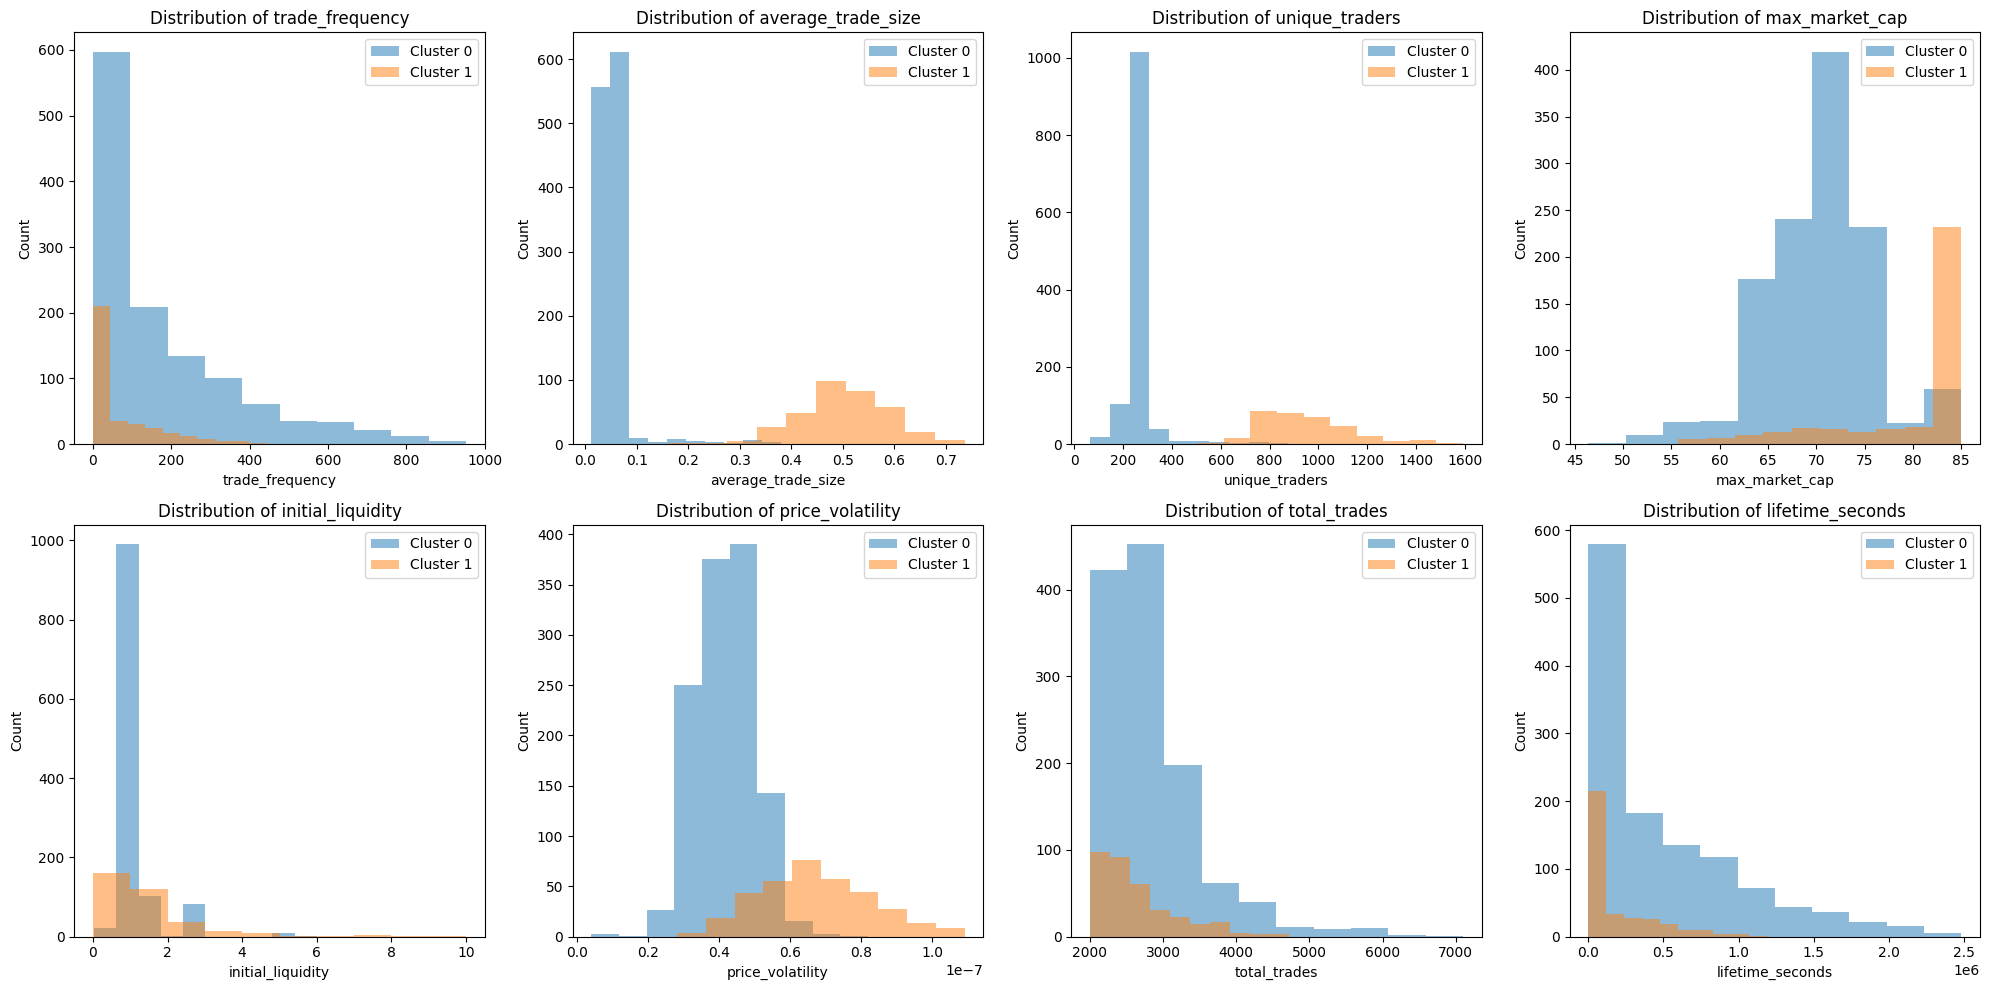

In [11]:
# Step 2: Feature distributions by DBSCAN cluster
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust rows/cols if necessary
axes = axes.flatten()

# Loop through each feature and plot distributions
for i, feature in enumerate(features):
    # Loop through each cluster (ignoring noise label (-1))
    for cluster in set(dbscan_labels_ch):
        if cluster == -1:  # Skip noise points (-1)
            continue
        
        # Filter data for each cluster
        subset = df[df['dbscan_cluster'] == cluster]
        
        # Plot histogram for the feature
        axes[i].hist(subset[feature], alpha=0.5, label=f'Cluster {cluster}')
    
    # Set plot labels and titles
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [12]:
# Exclude noise points
valid_clusters = df[df['dbscan_cluster'] != -1]
unique_clusters = sorted(valid_clusters['dbscan_cluster'].unique())
global_mean = np.mean(X_scaled, axis=0)

cluster_profiles = []

# Compute mean of scaled features grouped by DBSCAN cluster
scaled_df = pd.DataFrame(X_scaled, columns=features)
scaled_df['cluster'] = dbscan_labels_ch

cluster_centers = scaled_df[scaled_df['cluster'] != -1].groupby('cluster').mean()

for i in unique_clusters:
    cluster_tokens = df[df['dbscan_cluster'] == i]
    cluster_center = cluster_centers.loc[i].values
    
    feature_deviations = cluster_center - global_mean
    sorted_features = np.argsort(-np.abs(feature_deviations))
    distinguishing_features = [features[j] for j in sorted_features[:3]]
    
    profile = {
        'Cluster': i,
        'Size': len(cluster_tokens),
        'Percentage': f"{100 * len(cluster_tokens) / len(df):.1f}%",
        'Top Features': distinguishing_features,
        'Description': ""
    }
    
    description = f"Cluster {i} is characterized by "
    for j, feature in enumerate(distinguishing_features):
        direction = "high" if feature_deviations[sorted_features[j]] > 0 else "low"
        description += f"{direction} {feature}"
        if j < len(distinguishing_features) - 1:
            description += ", "
    
    profile['Description'] = description
    cluster_profiles.append(profile)

# Create DataFrame
profiles_df = pd.DataFrame(cluster_profiles)
print("\nCluster Profiles:")

# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Show result
print(profiles_df[['Cluster', 'Size', 'Percentage', 'Top Features', 'Description']])

# Reset display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')


Cluster Profiles:
   Cluster  Size Percentage  \
0        0  1208      60.4%   
1        1   347      17.4%   

                                             Top Features  \
0  [average_trade_size, unique_traders, price_volatility]   
1  [average_trade_size, unique_traders, price_volatility]   

                                                                                         Description  
0     Cluster 0 is characterized by low average_trade_size, low unique_traders, low price_volatility  
1  Cluster 1 is characterized by high average_trade_size, high unique_traders, high price_volatility  


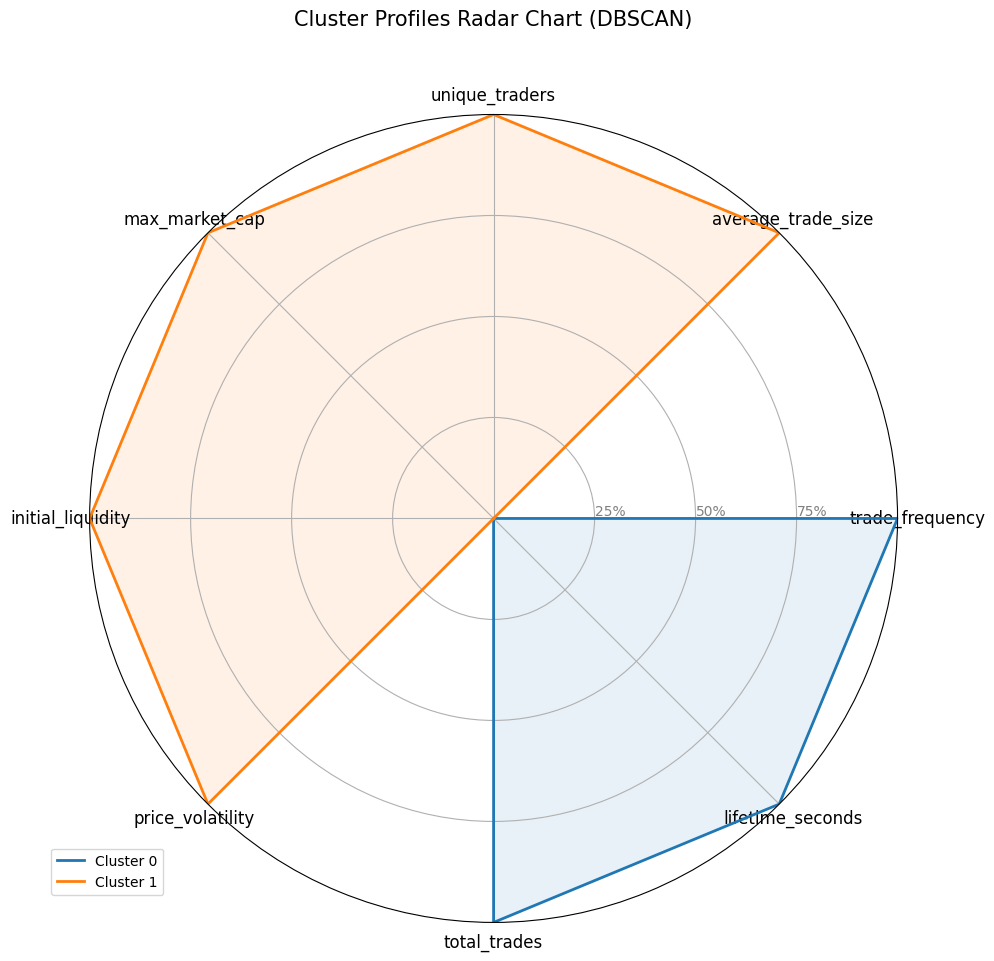

In [13]:
# Step 3: Calculate cluster profiles (mean feature values for each cluster)
# We will ignore the noise points (-1 label) for this step
cluster_profiles = df[df['dbscan_cluster'] != -1].groupby('dbscan_cluster')[features].mean()

# Step 4: Define the radar chart plotting function (same as before)
def plot_radar_chart(cluster_profiles, features):
    N = len(features)  # Number of features
    angles = [n / float(N) * 2 * np.pi for n in range(N)]  # Calculate angles for each feature
    angles += angles[:1]  # Close the loop
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per feature and add labels
    plt.xticks(angles[:-1], features, size=12)
    
    # Draw the y-axis labels (0-100%)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # Plot each cluster's profile
    for i, cluster_center in cluster_profiles.iterrows():
        # Normalize the cluster center values for radar chart (0-1 scale)
        values = cluster_center.values.tolist()
        min_vals = cluster_profiles.min()
        max_vals = cluster_profiles.max()
        normalized_values = [
            (val - min_val) / (max_val - min_val) if max_val > min_val else 0.5
            for val, min_val, max_val in zip(values, min_vals, max_vals)
        ]
        
        normalized_values += normalized_values[:1]  # Close the loop
        
        # Plot the radar chart for this cluster
        ax.plot(angles, normalized_values, linewidth=2, linestyle='solid', label=f"Cluster {i}")
        ax.fill(angles, normalized_values, alpha=0.1)
    
    # Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Cluster Profiles Radar Chart (DBSCAN)", size=15, y=1.1)
    
    plt.tight_layout()
    plt.show()

# Step 5: Plot the radar chart for DBSCAN clusters
plot_radar_chart(cluster_profiles, features)

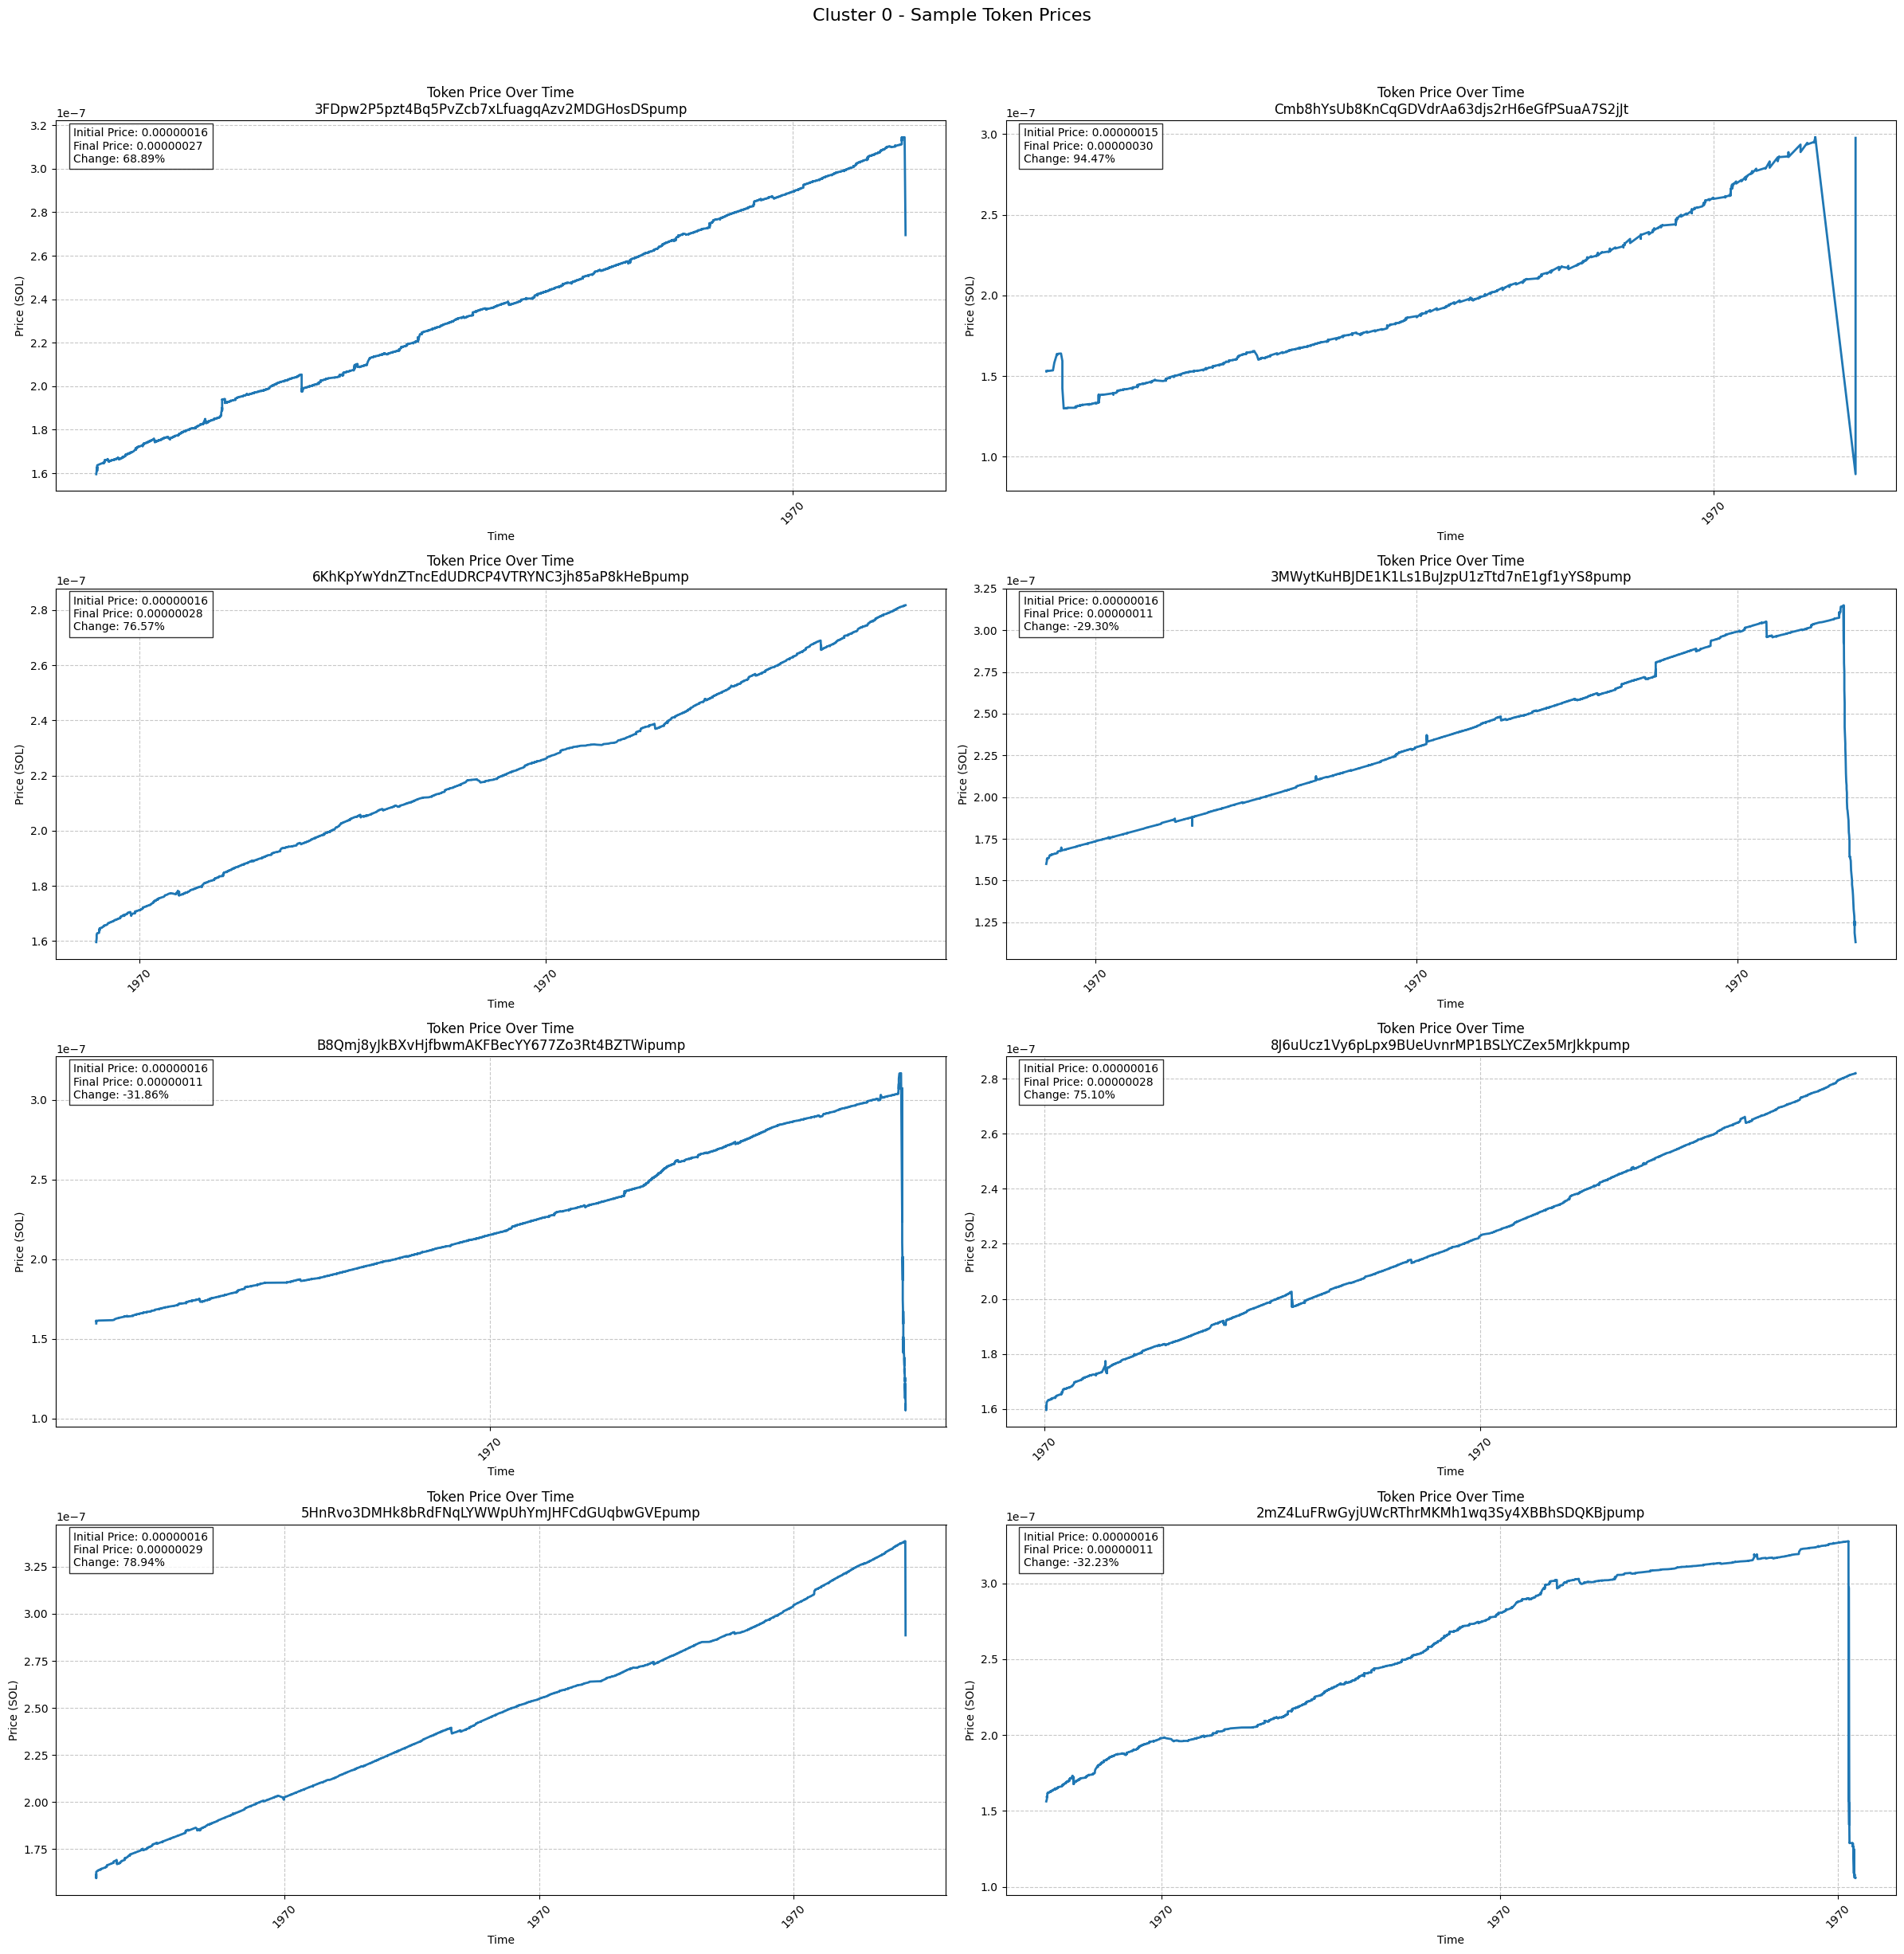

Created price plot for 8 tokens from cluster 0


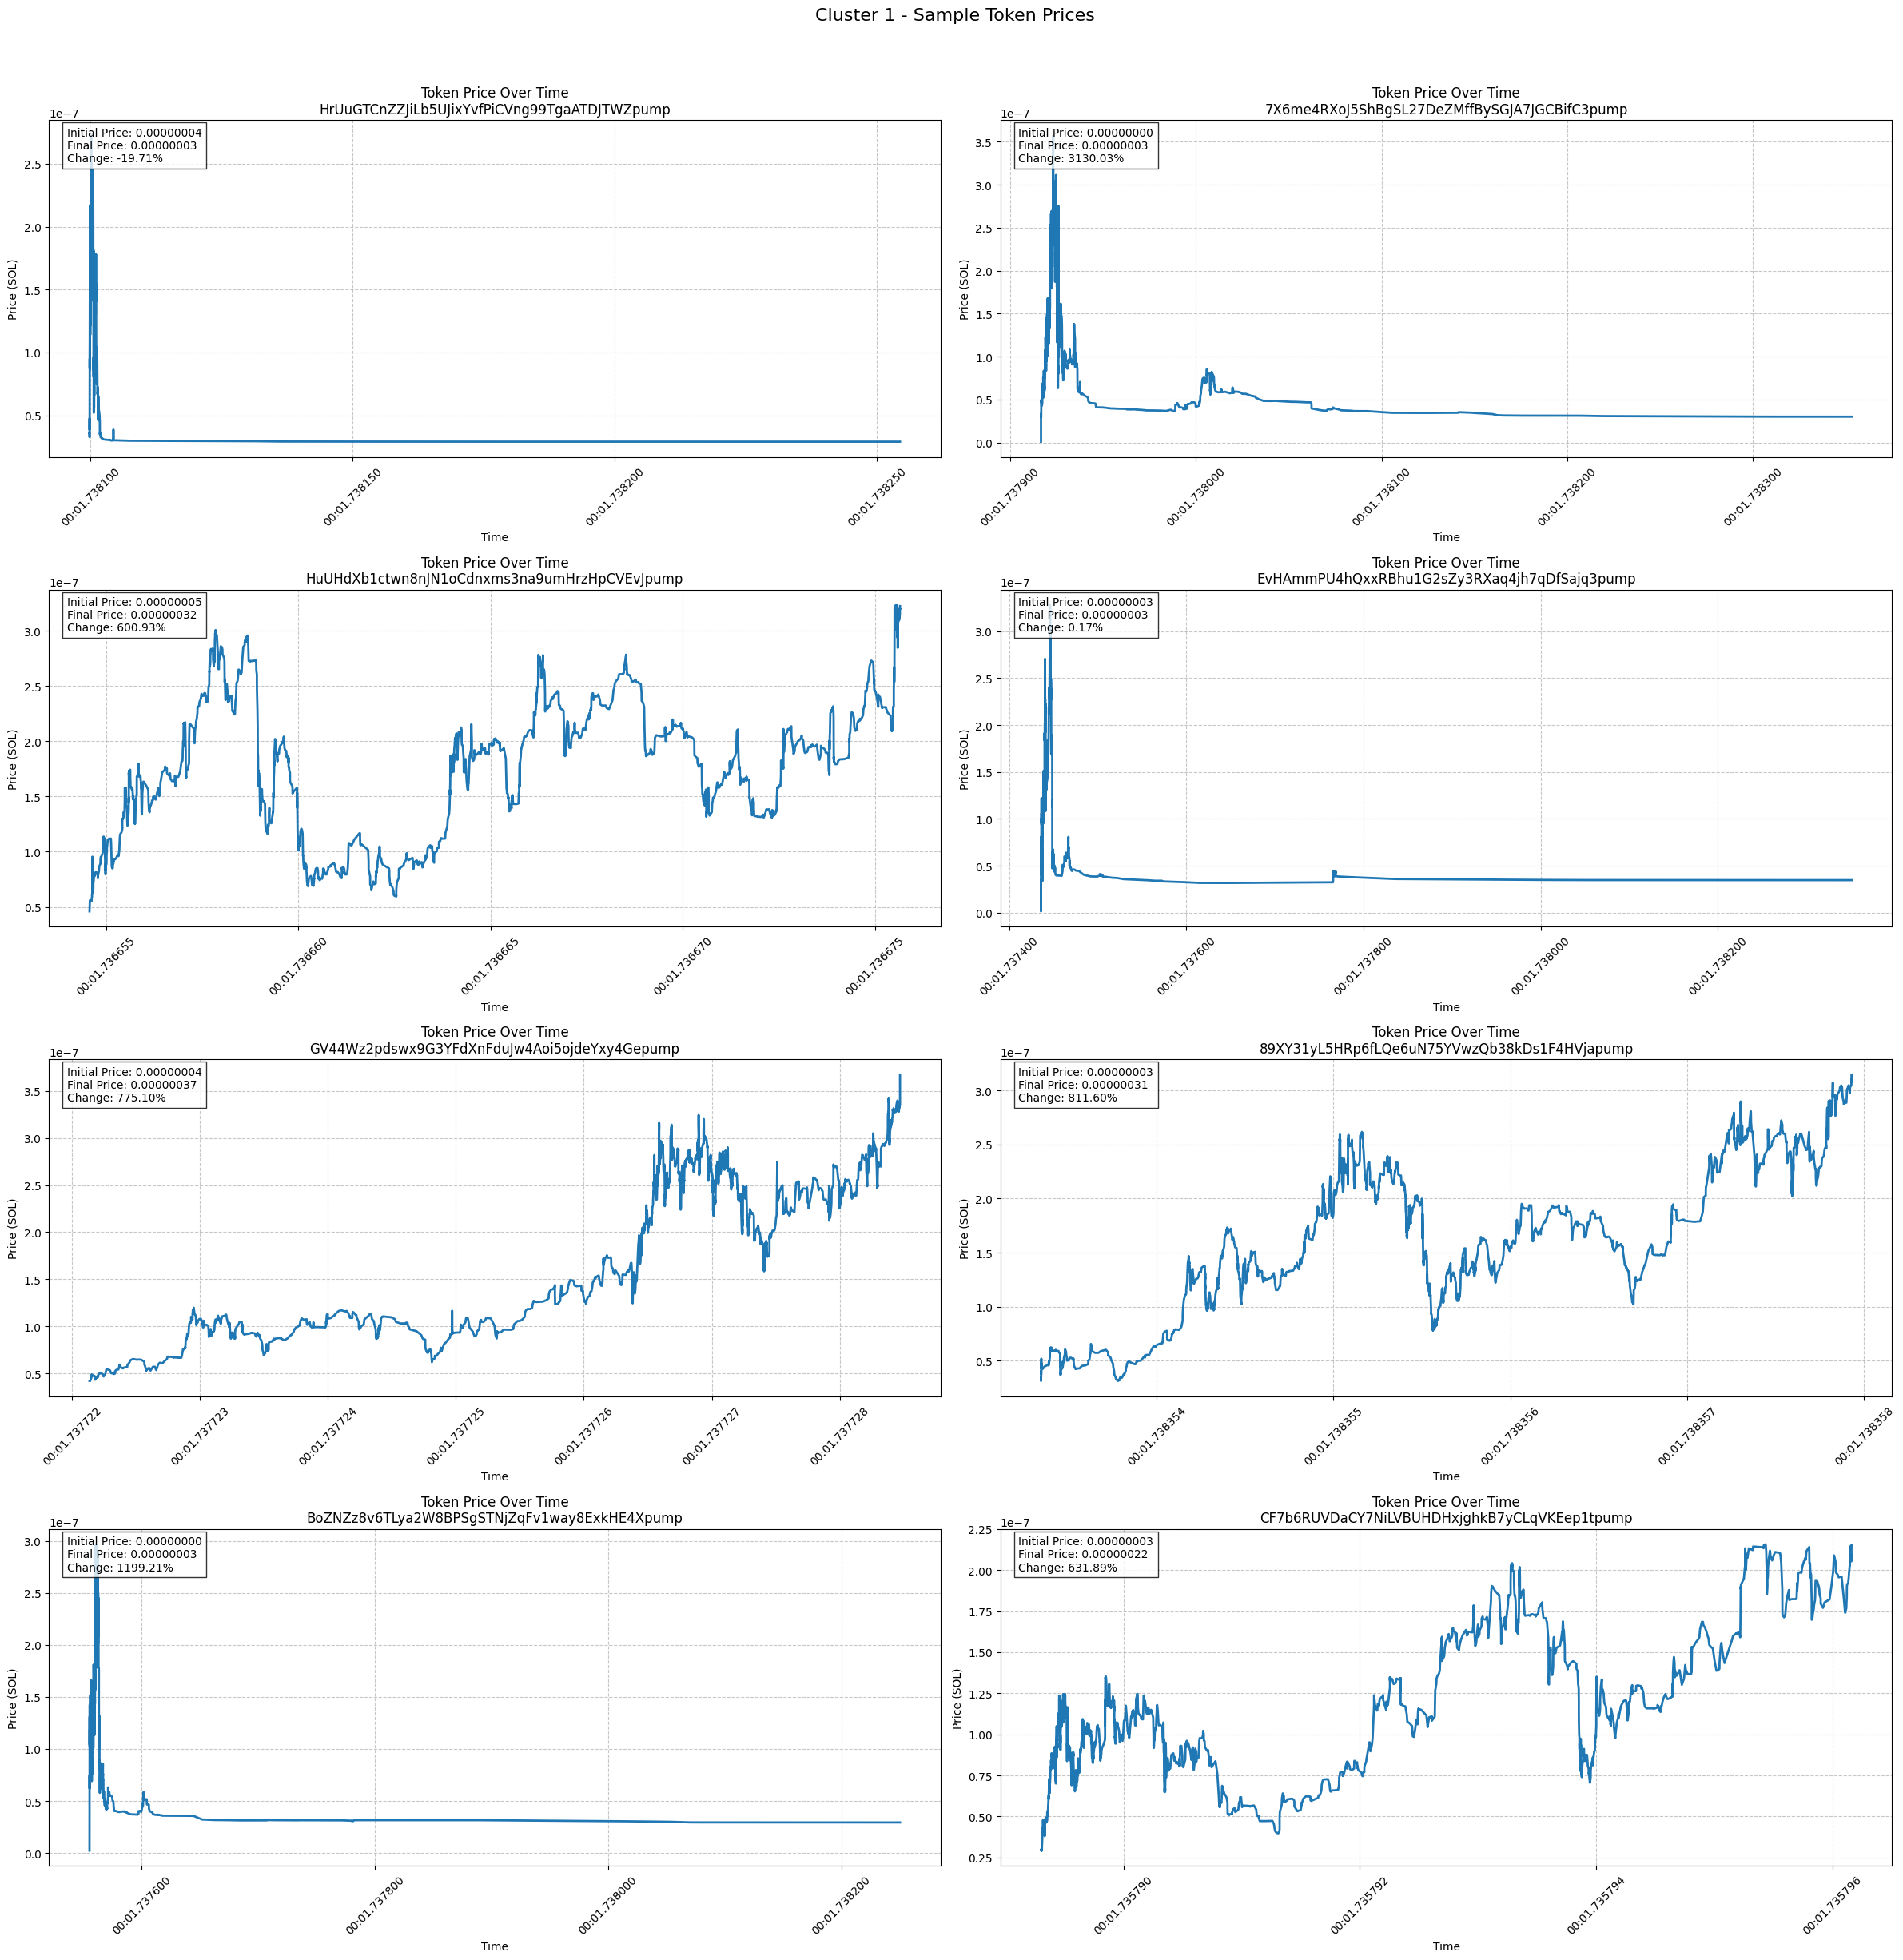

Created price plot for 8 tokens from cluster 1


In [14]:
from src.visualisation.price_plotter import plot_token_price
# For each DBSCAN cluster, plot 8 random tokens
for cluster_id in set(dbscan_labels_ch):
    if cluster_id == -1:  # Skip noise points
        continue
    
    # Filter the dataframe to get only tokens in this cluster
    cluster_tokens = df[df['dbscan_cluster'] == cluster_id]
    
    # Make sure we don't try to sample more tokens than we have
    sample_size = min(8, len(cluster_tokens))
    
    if sample_size > 0:
        # Sample 8 random tokens (or fewer if the cluster has less than 8)
        random_tokens = cluster_tokens.sample(n=sample_size, random_state=42)
        
        # Get the token addresses
        token_addresses = random_tokens['token_address'].tolist()
        
        # Plot the tokens (assuming you have a function `plot_token_price`)
        plot_title = f"Cluster {cluster_id} - Sample Token Prices"
        plot_token_price(token_addresses, title=plot_title)
        
        print(f"Created price plot for {sample_size} tokens from cluster {cluster_id}")
    else:
        print(f"Cluster {cluster_id} is empty, no plot created")


In [16]:
# Cluster 0 is scammy tokens

# Cluster 1 is legit tokens

# Export legit tokens to file
with open("db_scan_tokens.txt", "w") as f:
    for token_address in df[df['dbscan_cluster'] == 1]['token_address']:
        f.write(token_address + "\n")